In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from PIL import Image

In [2]:
# directories
image_dir = "./stimuli/"
res_dir = "./results/" 

### Load and prepare data

In [3]:
# Create image directory if it does not exist
if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

    # unzip data
    with zipfile.ZipFile('data_1_x_2_300.zip', 'r') as zip_ref:
        zip_ref.extractall(image_dir)

In [4]:
# read in the continuous index csv as DataFrame
if not os.path.isfile(res_dir + "cidx_avg.csv"):
    print("Error: Please run through the Data Preprocessing notebook!")
else: 
    cidx = pd.read_csv(res_dir + "cidx_avg.csv", index_col="filename")

In [5]:
# read in images
files = [image_dir + filename for filename in cidx.index.values]
images = np.stack([np.array(Image.open(file).convert("L")) for file in files])

# get the mean image
means = np.mean(images, axis=0)

# construct the zero-mean images
zero_mean_images = (images - means).reshape(images.shape[0], -1)

### Create model from Continuous Index

In [6]:
# Perform PCA on the zero-mean images
pca = PCA(n_components=None)
S = pca.fit_transform(zero_mean_images)
A = pca.components_

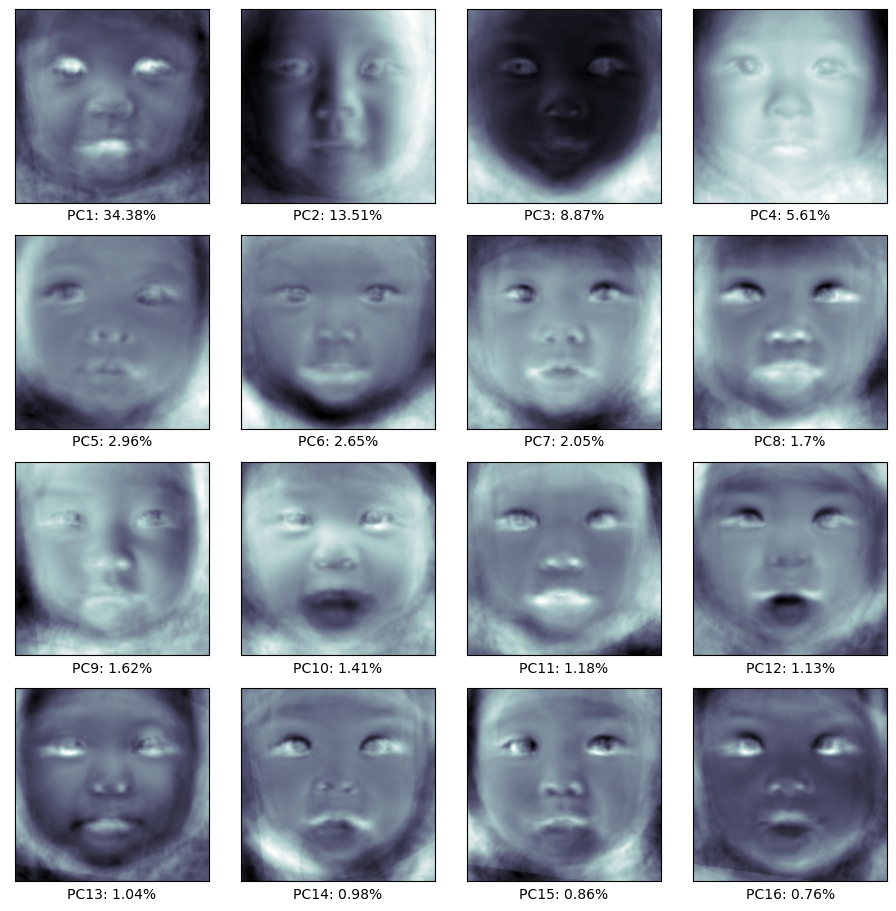

In [7]:
# Display some PCs
A_img = A.reshape(images.shape[0], 200, 200)
fig, ax = plt.subplots(4, 4, figsize=(9,9), constrained_layout=True)
for i in range(0,4):
    for j in range(0,4):
        ax[i,j].imshow( A_img[i * 4 + j]*pca.explained_variance_[i*4+j] + means , cmap="bone")
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xlabel(f"PC{i*4+j+1}: {round(pca.explained_variance_ratio_[i*4+j]*100,2)}%")
plt.savefig(res_dir + "principal_components.png")
plt.show()

In [8]:
n_max = 50
tolerance = 0.002 

# Greedy forward feature selection
features = np.full((images.shape[0]), False)
target = cidx.values
old_score = np.inf
for j in range(n_max):
    # Keep track of scores
    scores = np.full((images.shape[0]), np.inf)

    # calculate MSE for each enabled feature
    for i in range(len(features)):
        # Skip already selected features
        if features[i]:
            continue

        # Temporarily select feature 'i'
        features[i] = True

        # get reconstruction
        comps = pca.components_[features]
        X = zero_mean_images @ comps.T
        
        # Fit regression
        lr = LinearRegression()
        lr.fit(X, target)
        scores[i] = mean_squared_error(lr.predict(X),target)

        # Deselect feature 'i'
        features[i] = False
    
    # Pick feature with the lowest MSE-score if it improves
    # otherwise feature selection is done
    min_score = scores.min()
    if not min_score + tolerance < old_score:
        print(f"\nStopping since score decrease is not above tolerance.\nUsing {j+1} features with score {old_score}.")
        break
    features[scores.argmin()] = True
    old_score = min_score

    if (j+1) % 5 == 0:
        print(f'Iteration {j+1}/{n_max}: {min_score}')

Iteration 5/50: 0.23405104276581526
Iteration 10/50: 0.18838584621859056
Iteration 15/50: 0.15526015179133879
Iteration 20/50: 0.13542639385023272
Iteration 25/50: 0.11872309143431346
Iteration 30/50: 0.10476698547462891
Iteration 35/50: 0.09344629656856894

Stopping since score decrease is not above tolerance.
Using 38 features.


Get model parameters

In [9]:
# Fit linear regression using only selected features
comps = pca.components_[features]
X = zero_mean_images @ comps.T
lr = LinearRegression()
lr.fit(X, target)

# Extract model paramters
B = lr.coef_.T
d = lr.intercept_

Generate images across the continuous index

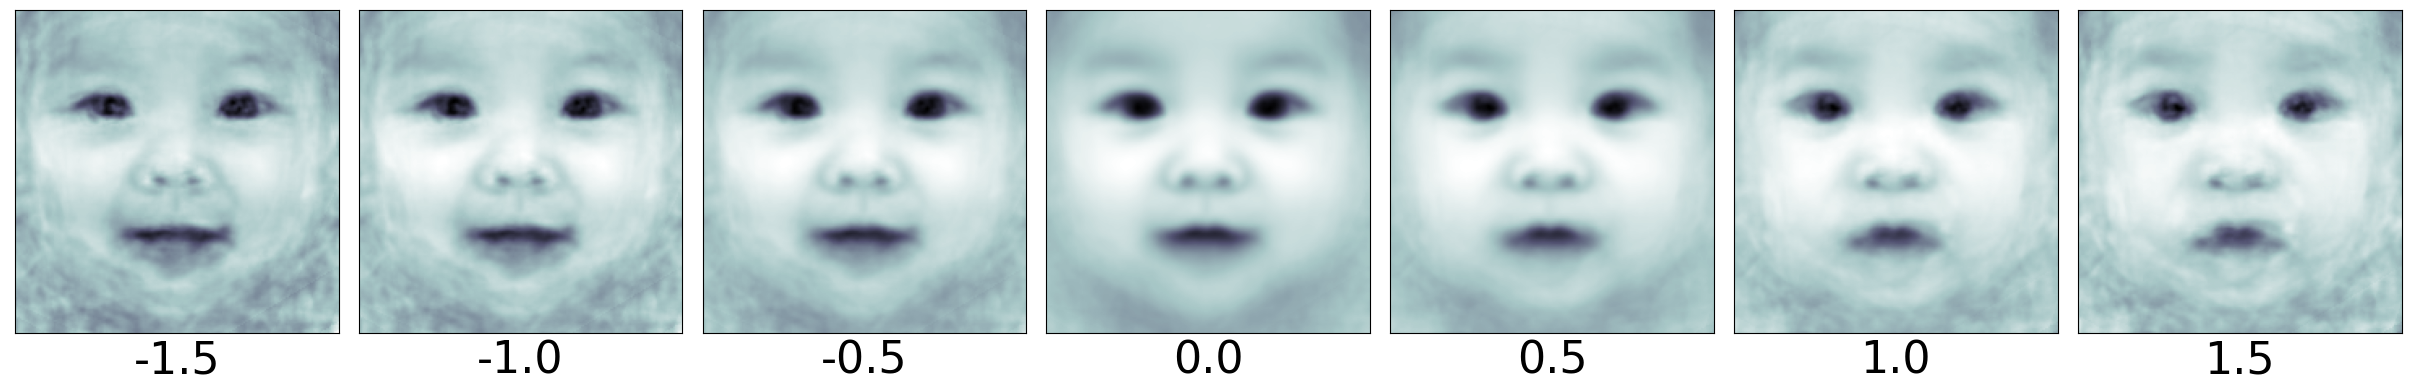

In [10]:
# define a continuous index range to generate images for
cidx_range = np.array([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# generate and display images for the defined range
fig, ax = plt.subplots(1, len(cidx_range), constrained_layout=True, figsize=(24,6))
for i in range(len(cidx_range)):
    # generate and save image
    img = ((cidx_range[i] - d) @ np.linalg.pinv(B) @ np.linalg.pinv(comps.T)).reshape(200, 200) + means
    plt.imsave(f'{res_dir}gen_faces/cidx_{i}.jpg', img, cmap="bone")

    # add image to plot
    ax[i].imshow(img, cmap="bone")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel(f"{cidx_range[i]}", fontsize=32)
plt.savefig(res_dir + "cidx_generated_images.png", bbox_inches="tight")
plt.show()

### Generate Continuum from mean images

In [11]:
# Compute the mean smiling and non-smiling images
mask = (cidx.values > 0).flatten()
mean_nosmile_images = images[mask].mean(axis=0)
mean_smile_images = images[~mask].mean(axis=0)

# Create direction vector between the two means
direction_vector = mean_nosmile_images - mean_smile_images

# Create a step vector
steps = np.linspace(-0.5, 1.5, 7)

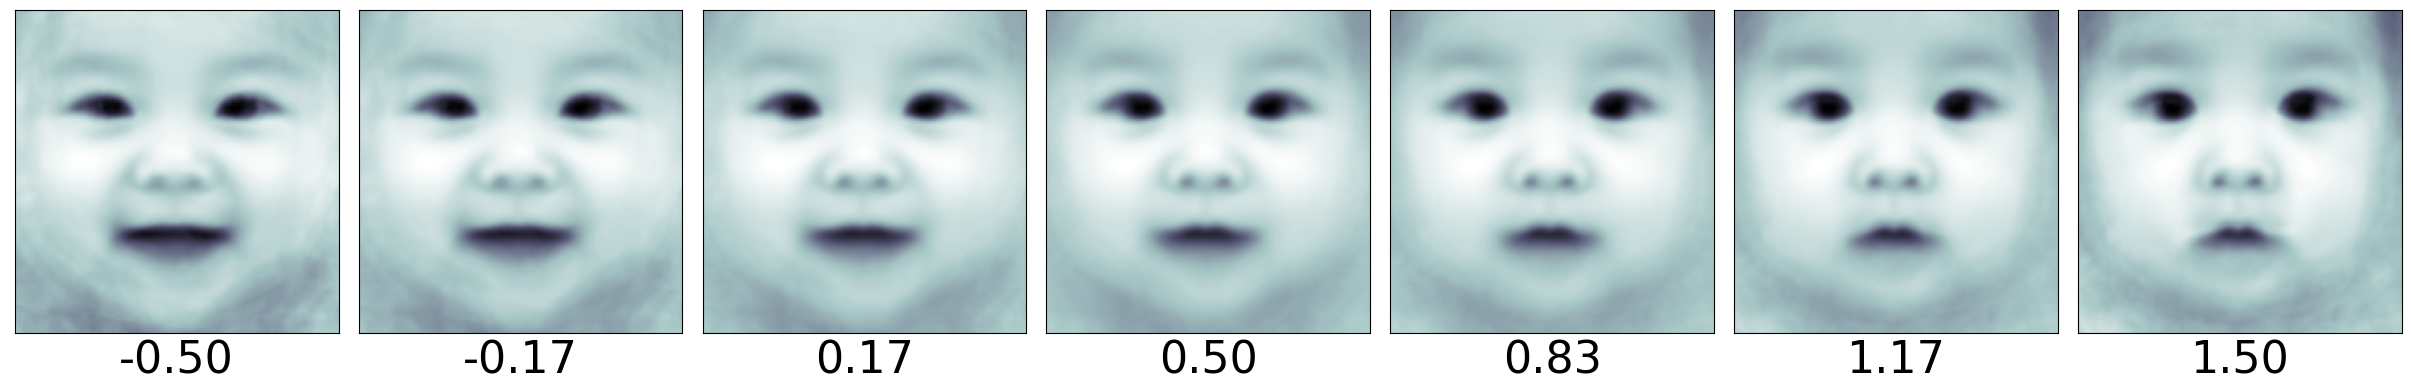

In [12]:
# Generate and display images between the two mean images, and an outlier for each
fig, ax = plt.subplots(1, len(steps), constrained_layout=True, figsize=(24, 6))
for i in range(len(steps)):
    # generate and save image
    img = mean_smile_images + steps[i] * direction_vector
    plt.imsave(f'{res_dir}gen_faces/mean_{i}.jpg', img, cmap="bone")

    # add image to plot
    ax[i].imshow(img, cmap="bone")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel("{:.2f}".format(steps[i]), fontsize=32)
plt.savefig(res_dir + "mean_generated_images.png", bbox_inches="tight")
plt.show()

### Generate Continuum from mean of reconstructed images

In [13]:
# Get reconstructed images from PCA, 
# that captures 90% explained variance
pca_ = PCA(n_components=0.9)
S = pca_.fit_transform(zero_mean_images)
A = pca_.components_
X = (S @ A).reshape(-1, 200, 200) + means

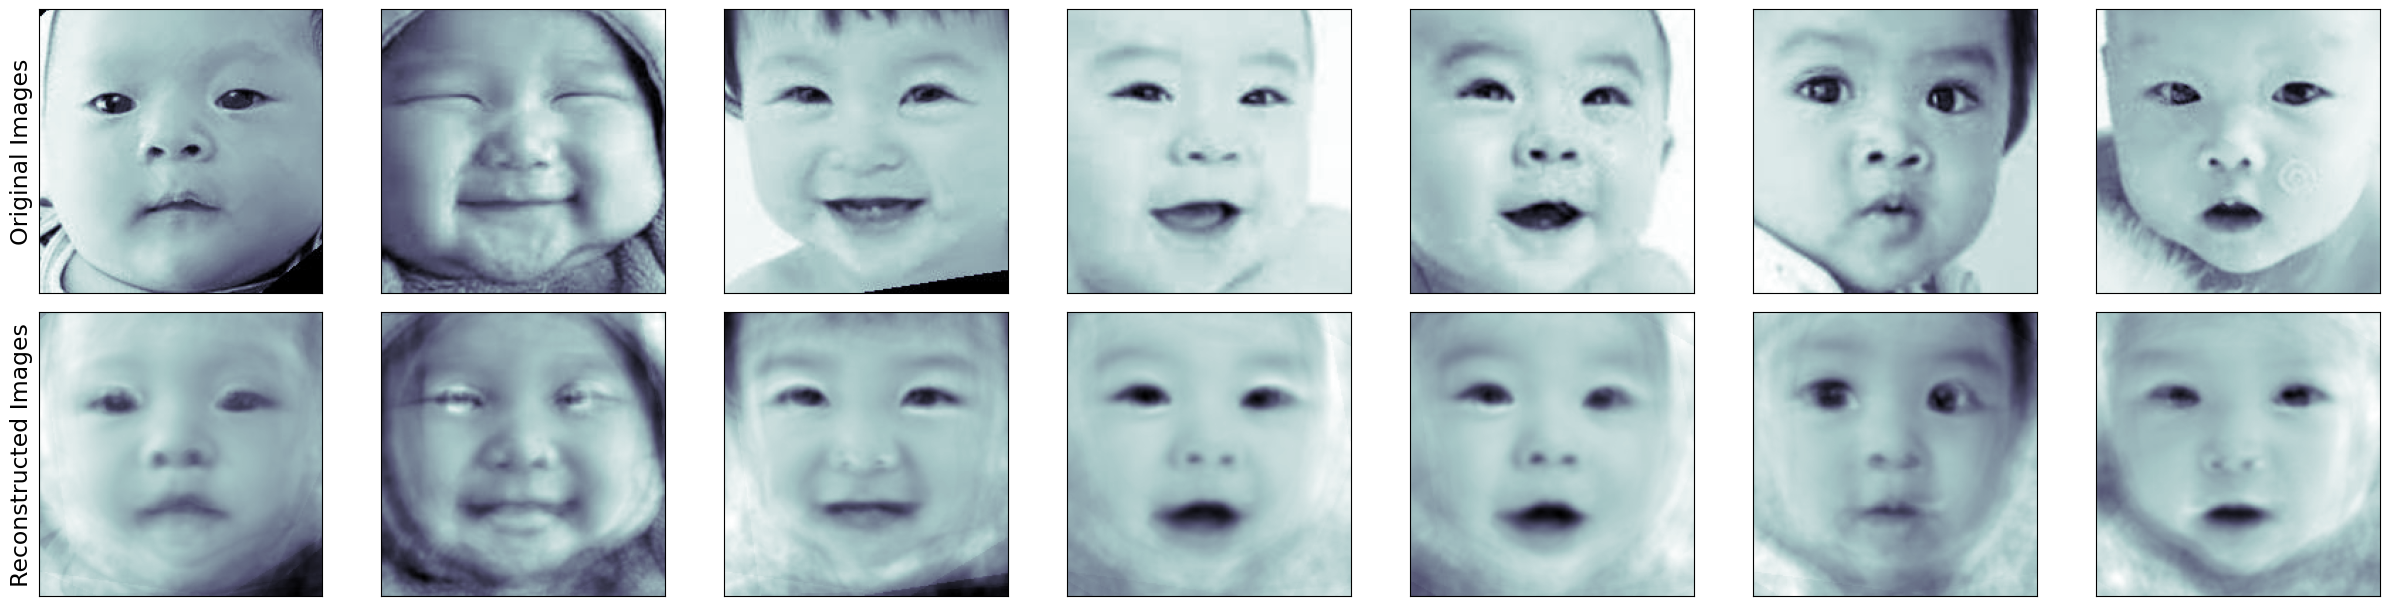

In [14]:
# Display 7 baby images and their reconstruction
n_bebs = 7
fig, ax = plt.subplots(2, n_bebs, constrained_layout=True, figsize=(24, 6))
for i in range(n_bebs):
    ax[0, i].imshow(images[i], cmap='bone')
    ax[1, i].imshow(X[i], cmap='bone')
    for j in range(2):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[0, 0].set_ylabel('Original Images', fontsize=17)
ax[1, 0].set_ylabel('Reconstructed Images', fontsize=17)
plt.savefig(res_dir + "img_reconstructions.png", bbox_inches="tight")
plt.show()

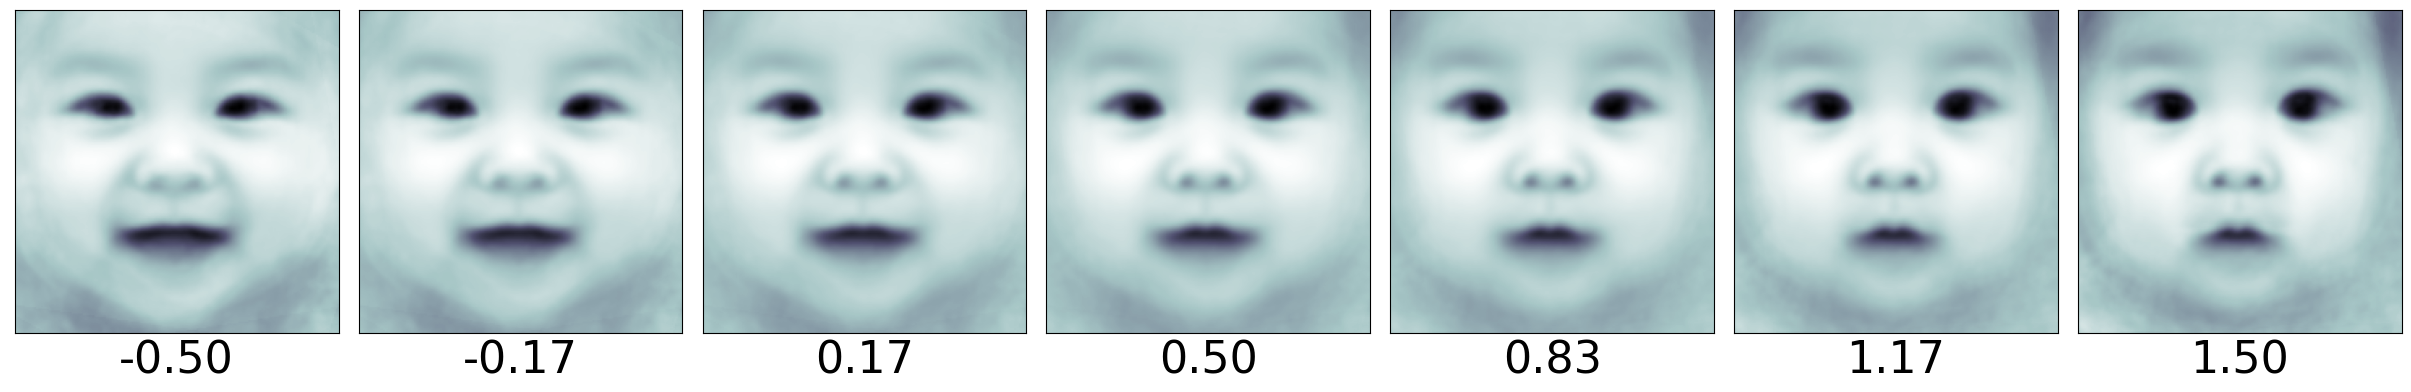

In [15]:
# Calculate mean of reconstructed images
mean_nosmile_images_recon = X[mask].mean(axis=0)
mean_smile_images_recon = X[~mask].mean(axis=0)

# Create direction vector between the two means
direction_vector = mean_nosmile_images_recon - mean_smile_images_recon

# Generate and display images between the two mean reconstructed images, and an outlier for each
fig, ax = plt.subplots(1, len(steps), constrained_layout=True, figsize=(24,6))
for i in range(len(steps)):
    # Generate and save image
    img = mean_smile_images_recon + steps[i] * direction_vector
    plt.imsave(f'{res_dir}gen_faces/recon_mean_{i}.jpg', img, cmap="bone")

    # add image to plot
    ax[i].imshow(img, cmap="bone")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel("{:.2f}".format(steps[i]), fontsize=32)
plt.savefig(res_dir + "mean_generated_recon_images.png", bbox_inches="tight")
plt.show()